# Red nauronal convolucional 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## 1.- Pipeline
- El dataset CIFAR-10 consiste en imágenes de resolución de $32 \times 32$. Al ser imágenes RGB, se tienen 3 canales.

In [2]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Convert y_train and y_test to one hot 
y_train = tf.keras.utils.to_categorical(
    y_train, num_classes=num_classes, dtype='float32'
)

y_test = tf.keras.utils.to_categorical(
    y_test, num_classes=num_classes, dtype='float32'
)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


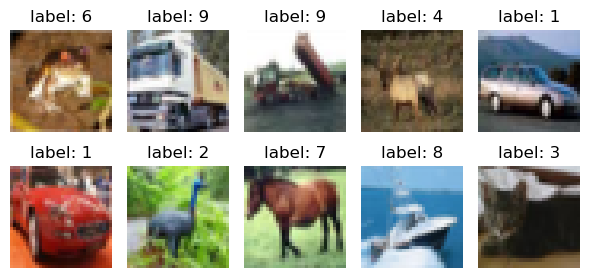

In [3]:
# Define a function to plot images with titles
def plot_images(images, labels):
    fig, axes = plt.subplots(2, 5, figsize=(6, 3))
    axes = axes.flatten()
    
    for i in range(len(images)):
        axes[i].imshow(images[i])
        axes[i].set_title(labels[i])
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Select a batch of images and their corresponding targets
n = 10
batch_images = x_train[:n]
batch_labels = [f"label: {label.argmax()}" for label in y_train[:n]]

# Plot the batch of images
plot_images(batch_images, batch_labels)

In [4]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 10))

In [5]:
ds_len = len(x_train)
batch_size = 64

In [6]:
x_train = tf.data.Dataset.from_tensor_slices(x_train)
y_train = tf.data.Dataset.from_tensor_slices(y_train)

x_test = tf.data.Dataset.from_tensor_slices(x_test)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

train_ds = tf.data.Dataset.zip((x_train, y_train))
train_ds = train_ds.shuffle(len(train_ds)).batch(batch_size)

test_ds = tf.data.Dataset.zip((x_test, y_test))
test_ds = test_ds.batch(batch_size)

test_batch = next(iter(train_ds))
test_batch[0].shape, test_batch[1].shape

(TensorShape([64, 32, 32, 3]), TensorShape([64, 10]))

## 2.- Modelo
- Definir una clase Conv2D.

In [7]:
class Conv2D(layers.Layer):
    def __init__(self, filters, kernel_size, 
                 strides=1, padding='VALID'):
        super(Conv2D, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                                      shape=[self.kernel_size, 
                                             self.kernel_size,
                                             input_shape[-1],
                                             self.filters])

    def call(self, inputs):
        x = tf.nn.conv2d(inputs, self.kernel, 
                         strides=[1, self.strides, self.strides, 1],
                         padding=self.padding)
        return x


layer = Conv2D(5, 2, padding='SAME')
layer(tf.ones([1, 32, 32, 3]))

<tf.Tensor: shape=(1, 32, 32, 5), dtype=float32, numpy=
array([[[[-1.1705078 , -0.82858473, -0.7023369 , -1.1065221 ,
           1.5173693 ],
         [-1.1705078 , -0.82858473, -0.7023369 , -1.1065221 ,
           1.5173693 ],
         [-1.1705078 , -0.82858473, -0.7023369 , -1.1065221 ,
           1.5173693 ],
         ...,
         [-1.1705078 , -0.82858473, -0.7023369 , -1.1065221 ,
           1.5173693 ],
         [-1.1705078 , -0.82858473, -0.7023369 , -1.1065221 ,
           1.5173693 ],
         [-0.5583525 , -0.736482  , -0.06194422, -0.5080222 ,
           0.1062654 ]],

        [[-1.1705078 , -0.82858473, -0.7023369 , -1.1065221 ,
           1.5173693 ],
         [-1.1705078 , -0.82858473, -0.7023369 , -1.1065221 ,
           1.5173693 ],
         [-1.1705078 , -0.82858473, -0.7023369 , -1.1065221 ,
           1.5173693 ],
         ...,
         [-1.1705078 , -0.82858473, -0.7023369 , -1.1065221 ,
           1.5173693 ],
         [-1.1705078 , -0.82858473, -0.7023369 , -1.10

- Prueba la capa convolucional.

In [8]:
test_layer = Conv2D(
    filters=5,
    kernel_size=3,
    strides = 1,
    padding='SAME'
    )

test_output = test_layer(test_batch[0])
test_output.shape

TensorShape([64, 32, 32, 5])

In [9]:
tf.keras.layers.Flatten()(test_output).shape

TensorShape([64, 5120])

## 3.- Entrenamiento

In [10]:
epochs = 10
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

- Una sola capa convolucional.

In [11]:
model = tf.keras.Sequential([
    Conv2D(filters=10, kernel_size=3,
           strides = 2, padding='VALID'),
    layers.Flatten(),
    layers.Dense(10),
])

optimizer = tf.keras.optimizers.Adam(0.0001)

model.compile(loss=loss_fn,
              optimizer=optimizer)

history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs, verbose=1)

Epoch 1/10
782/782 [==============================] - 2s 2ms/step - loss: 2.0291 - val_loss: 1.9039
Epoch 2/10
782/782 [==============================] - 1s 1ms/step - loss: 1.8719 - val_loss: 1.8497
Epoch 3/10
782/782 [==============================] - 1s 1ms/step - loss: 1.8264 - val_loss: 1.8131
Epoch 4/10
782/782 [==============================] - 1s 1ms/step - loss: 1.8008 - val_loss: 1.7908
Epoch 5/10
782/782 [==============================] - 1s 1ms/step - loss: 1.7842 - val_loss: 1.7773
Epoch 6/10
782/782 [==============================] - 1s 1ms/step - loss: 1.7715 - val_loss: 1.7748
Epoch 7/10
782/782 [==============================] - 1s 1ms/step - loss: 1.7622 - val_loss: 1.7617
Epoch 8/10
782/782 [==============================] - 1s 1ms/step - loss: 1.7537 - val_loss: 1.7598
Epoch 9/10
782/782 [==============================] - 1s 1ms/step - loss: 1.7477 - val_loss: 1.7520
Epoch 10/10
782/782 [==============================] - 1s 1ms/step - loss: 1.7405 - val_loss: 1.7458

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 15, 15, 10)        270       
                                                                 
 flatten_1 (Flatten)         (None, 2250)              0         
                                                                 
 dense (Dense)               (None, 10)                22510     
                                                                 
Total params: 22,780
Trainable params: 22,780
Non-trainable params: 0
_________________________________________________________________


- Agregando más capas convolucionales, activaciones y normalizando por lotes.

In [13]:
model = tf.keras.Sequential([
    Conv2D(filters=16, kernel_size=3,
                  strides = 2, padding='VALID'),
    layers.BatchNormalization(),
    layers.ReLU(),
    Conv2D(filters=32, kernel_size=3,
                  strides=2, padding='VALID'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10),
])

optimizer = tf.keras.optimizers.Adam(0.0001)

model.compile(loss=loss_fn,
              optimizer=optimizer, metrics=['accuracy'])

history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs, verbose=1)

Epoch 1/10
782/782 [==============================] - 3s 2ms/step - loss: 1.7060 - accuracy: 0.3915 - val_loss: 1.4973 - val_accuracy: 0.4681
Epoch 2/10
782/782 [==============================] - 2s 2ms/step - loss: 1.3941 - accuracy: 0.5060 - val_loss: 1.3568 - val_accuracy: 0.5222
Epoch 3/10
782/782 [==============================] - 2s 2ms/step - loss: 1.2467 - accuracy: 0.5591 - val_loss: 1.2700 - val_accuracy: 0.5453
Epoch 4/10
782/782 [==============================] - 2s 2ms/step - loss: 1.1446 - accuracy: 0.5981 - val_loss: 1.2097 - val_accuracy: 0.5632
Epoch 5/10
782/782 [==============================] - 2s 2ms/step - loss: 1.0660 - accuracy: 0.6300 - val_loss: 1.1845 - val_accuracy: 0.5778
Epoch 6/10
782/782 [==============================] - 2s 2ms/step - loss: 0.9993 - accuracy: 0.6553 - val_loss: 1.1608 - val_accuracy: 0.5835
Epoch 7/10
782/782 [==============================] - 1s 2ms/step - loss: 0.9418 - accuracy: 0.6757 - val_loss: 1.1314 - val_accuracy: 0.6001
Epoch 

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 15, 15, 16)        432       
                                                                 
 batch_normalization (BatchN  (None, 15, 15, 16)       64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 15, 15, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          4608      
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 32)         128       
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 7, 7, 32)         

## Ejercicio
- Modificar la arquitectura y el entrenamiento para obtener mejores resultados.